In [158]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest

# model imports
from sklearn.linear_model import LogisticRegression #linear model
from sklearn.svm import SVC # support vector machine
from sklearn.ensemble import RandomForestClassifier #ensemble model

from sklearn.inspection import permutation_importance

from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.options.display.max_columns = 100



In [51]:
def calculate_f1_scores_across_thresholds(model, X_val, y_val):
    """
    Calculate F1 scores for all thresholds from 0.0 to 1.0 with increment 0.01
    and find the threshold where F1 is maximal
    """
    
    # Get prediction probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Define threshold range from 0 to 1 with step 0.01
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    print("Calculating F1 scores for each threshold...")
    
    for threshold in thresholds:
        # Convert probabilities to predictions based on threshold
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate precision and recall
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        # Calculate F1 score using the formula: F1 = 2 * (P * R) / (P + R)
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Find the threshold with maximum F1 score
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    max_f1_score = f1_scores[max_f1_idx]
    optimal_precision = precisions[max_f1_idx]
    optimal_recall = recalls[max_f1_idx]
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: F1 Score vs Threshold
    axes[0, 0].plot(thresholds, f1_scores, 'g-', linewidth=2, marker='o', markersize=3)
    axes[0, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, 
                       label=f'Max F1 at {optimal_threshold:.2f}')
    axes[0, 0].axhline(y=max_f1_score, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title(f'F1 Score vs Threshold\nMax F1: {max_f1_score:.3f} at threshold {optimal_threshold:.2f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 1])
    axes[0, 0].set_ylim([0, 1])
    
    # Plot 2: Precision, Recall, and F1 together
    axes[0, 1].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[0, 1].plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    axes[0, 1].plot(thresholds, f1_scores, 'g-', label='F1 Score', linewidth=2)
    axes[0, 1].axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7,
                       label=f'Optimal threshold: {optimal_threshold:.2f}')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Precision, Recall, and F1 Score vs Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0, 1])
    axes[0, 1].set_ylim([0, 1])
    
    # Plot 3: Zoomed F1 Score around optimal threshold
    zoom_range = 0.1  # Show ±0.1 around optimal threshold
    zoom_min = max(0, optimal_threshold - zoom_range)
    zoom_max = min(1, optimal_threshold + zoom_range)
    
    zoom_mask = (thresholds >= zoom_min) & (thresholds <= zoom_max)
    axes[1, 0].plot(thresholds[zoom_mask], np.array(f1_scores)[zoom_mask], 'g-', 
                    linewidth=2, marker='o', markersize=4)
    axes[1, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].axhline(y=max_f1_score, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title(f'F1 Score (Zoomed)\nAround Optimal Threshold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Bar chart showing top 10 F1 scores
    top_10_indices = np.argsort(f1_scores)[-10:]
    top_10_thresholds = thresholds[top_10_indices]
    top_10_f1_scores = np.array(f1_scores)[top_10_indices]
    
    bars = axes[1, 1].bar(range(len(top_10_thresholds)), top_10_f1_scores, 
                          color=['red' if t == optimal_threshold else 'skyblue' for t in top_10_thresholds])
    axes[1, 1].set_xlabel('Rank (Best to 10th Best)')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_title('Top 10 F1 Scores')
    axes[1, 1].set_xticks(range(len(top_10_thresholds)))
    axes[1, 1].set_xticklabels([f'{t:.2f}' for t in top_10_thresholds], rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print("F1 SCORE ANALYSIS RESULTS")
    print("="*60)
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum F1 Score: {max_f1_score:.3f}")
    print(f"Precision at optimal threshold: {optimal_precision:.3f}")
    print(f"Recall at optimal threshold: {optimal_recall:.3f}")
    print(f"F1 Formula verification: 2*P*R/(P+R) = 2*{optimal_precision:.3f}*{optimal_recall:.3f}/({optimal_precision:.3f}+{optimal_recall:.3f}) = {max_f1_score:.3f}")
    
    # Show top 5 thresholds with highest F1 scores
    print("\nTop 5 thresholds with highest F1 scores:")
    print("-" * 40)
    top_5_indices = np.argsort(f1_scores)[-5:][::-1]  # Get top 5 in descending order
    for i, idx in enumerate(top_5_indices, 1):
        print(f"{i}. Threshold: {thresholds[idx]:.2f}, F1: {f1_scores[idx]:.3f}, "
              f"Precision: {precisions[idx]:.3f}, Recall: {recalls[idx]:.3f}")
    
    return thresholds, f1_scores, optimal_threshold, max_f1_score

# Simple version for quick usage
def find_optimal_f1_threshold(model, X_val, y_val):
    """
    Simple function to find optimal F1 threshold and create basic plot
    """
    y_prob = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    
    # Find optimal threshold
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    max_f1_score = f1_scores[max_f1_idx]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'g-', linewidth=2, marker='o', markersize=3)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.8, 
                label=f'Max F1: {max_f1_score:.3f} at {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum F1 Score: {max_f1_score:.3f}")
    
    return optimal_threshold, max_f1_score

# Import Dataset

Dataset Details

This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default. 

link to dataset: https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients

Variables Name



In [111]:
df =  pd.read_csv('../data/default_credit_dataset.csv', sep=';', dtype=str)

## Data Understanding and Preprocessing

In [112]:
df.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
8221,8222,10000,1,2,1,43,3,2,2,4,3,2,8261,9470,11163,10852,10396,10085,1500,2000,0,0,0,350,1
16313,16314,70000,2,2,3,45,0,0,0,0,0,0,70820,66163,67605,68855,70377,67818,2500,2507,2428,2594,2602,2500,0
11704,11705,30000,2,3,1,22,1,2,0,0,4,4,21508,20881,23217,28498,28060,29999,0,3000,6000,1200,3000,0,1
9091,9092,240000,2,3,2,50,0,0,0,0,0,0,223045,218120,221051,191997,196221,200058,9490,8163,6753,7197,7176,5265,0
24339,24340,360000,1,3,2,34,-1,-1,-1,-1,-1,-1,686,3821,1937,944,1219,2216,3821,1937,944,1219,2216,2000,0


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          30000 non-null  object
 1   LIMIT_BAL                   30000 non-null  object
 2   SEX                         30000 non-null  object
 3   EDUCATION                   30000 non-null  object
 4   MARRIAGE                    30000 non-null  object
 5   AGE                         30000 non-null  object
 6   PAY_0                       30000 non-null  object
 7   PAY_2                       30000 non-null  object
 8   PAY_3                       30000 non-null  object
 9   PAY_4                       30000 non-null  object
 10  PAY_5                       30000 non-null  object
 11  PAY_6                       30000 non-null  object
 12  BILL_AMT1                   30000 non-null  object
 13  BILL_AMT2                   30000 non-null  ob

In [114]:
# renaming column
df.rename(columns={'default payment next month': 'default'}, inplace=True)

As there are no empty values in the dataset, we can proceed to the next step.

### Transform Data

In [115]:
for col in [col for col in df.columns if ('PAY_' in col) or (col.startswith('AGE')) or ('BILL' in col) or ('LIMIT' in col) or ('default' in col)]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

## Define data type for features and target

In [116]:
target = 'default'

numeric_features = [
    'LIMIT_BAL', 
    'AGE',
    'PAY_0', 
    'PAY_2', 
    'PAY_3',
    'PAY_4', 
    'PAY_5', 
    'PAY_6',
    'BILL_AMT1', 
    'BILL_AMT2', 
    'BILL_AMT3',
    'BILL_AMT4', 
    'BILL_AMT5', 
    'BILL_AMT6', 
    'PAY_AMT1', 
    'PAY_AMT2',
    'PAY_AMT3', 
    'PAY_AMT4', 
    'PAY_AMT5', 
    'PAY_AMT6'
]

categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE'
]

In [117]:
# drop unused columns
df = df[categorical_features + numeric_features + [target]].copy()

## Exploratory Data Analysis

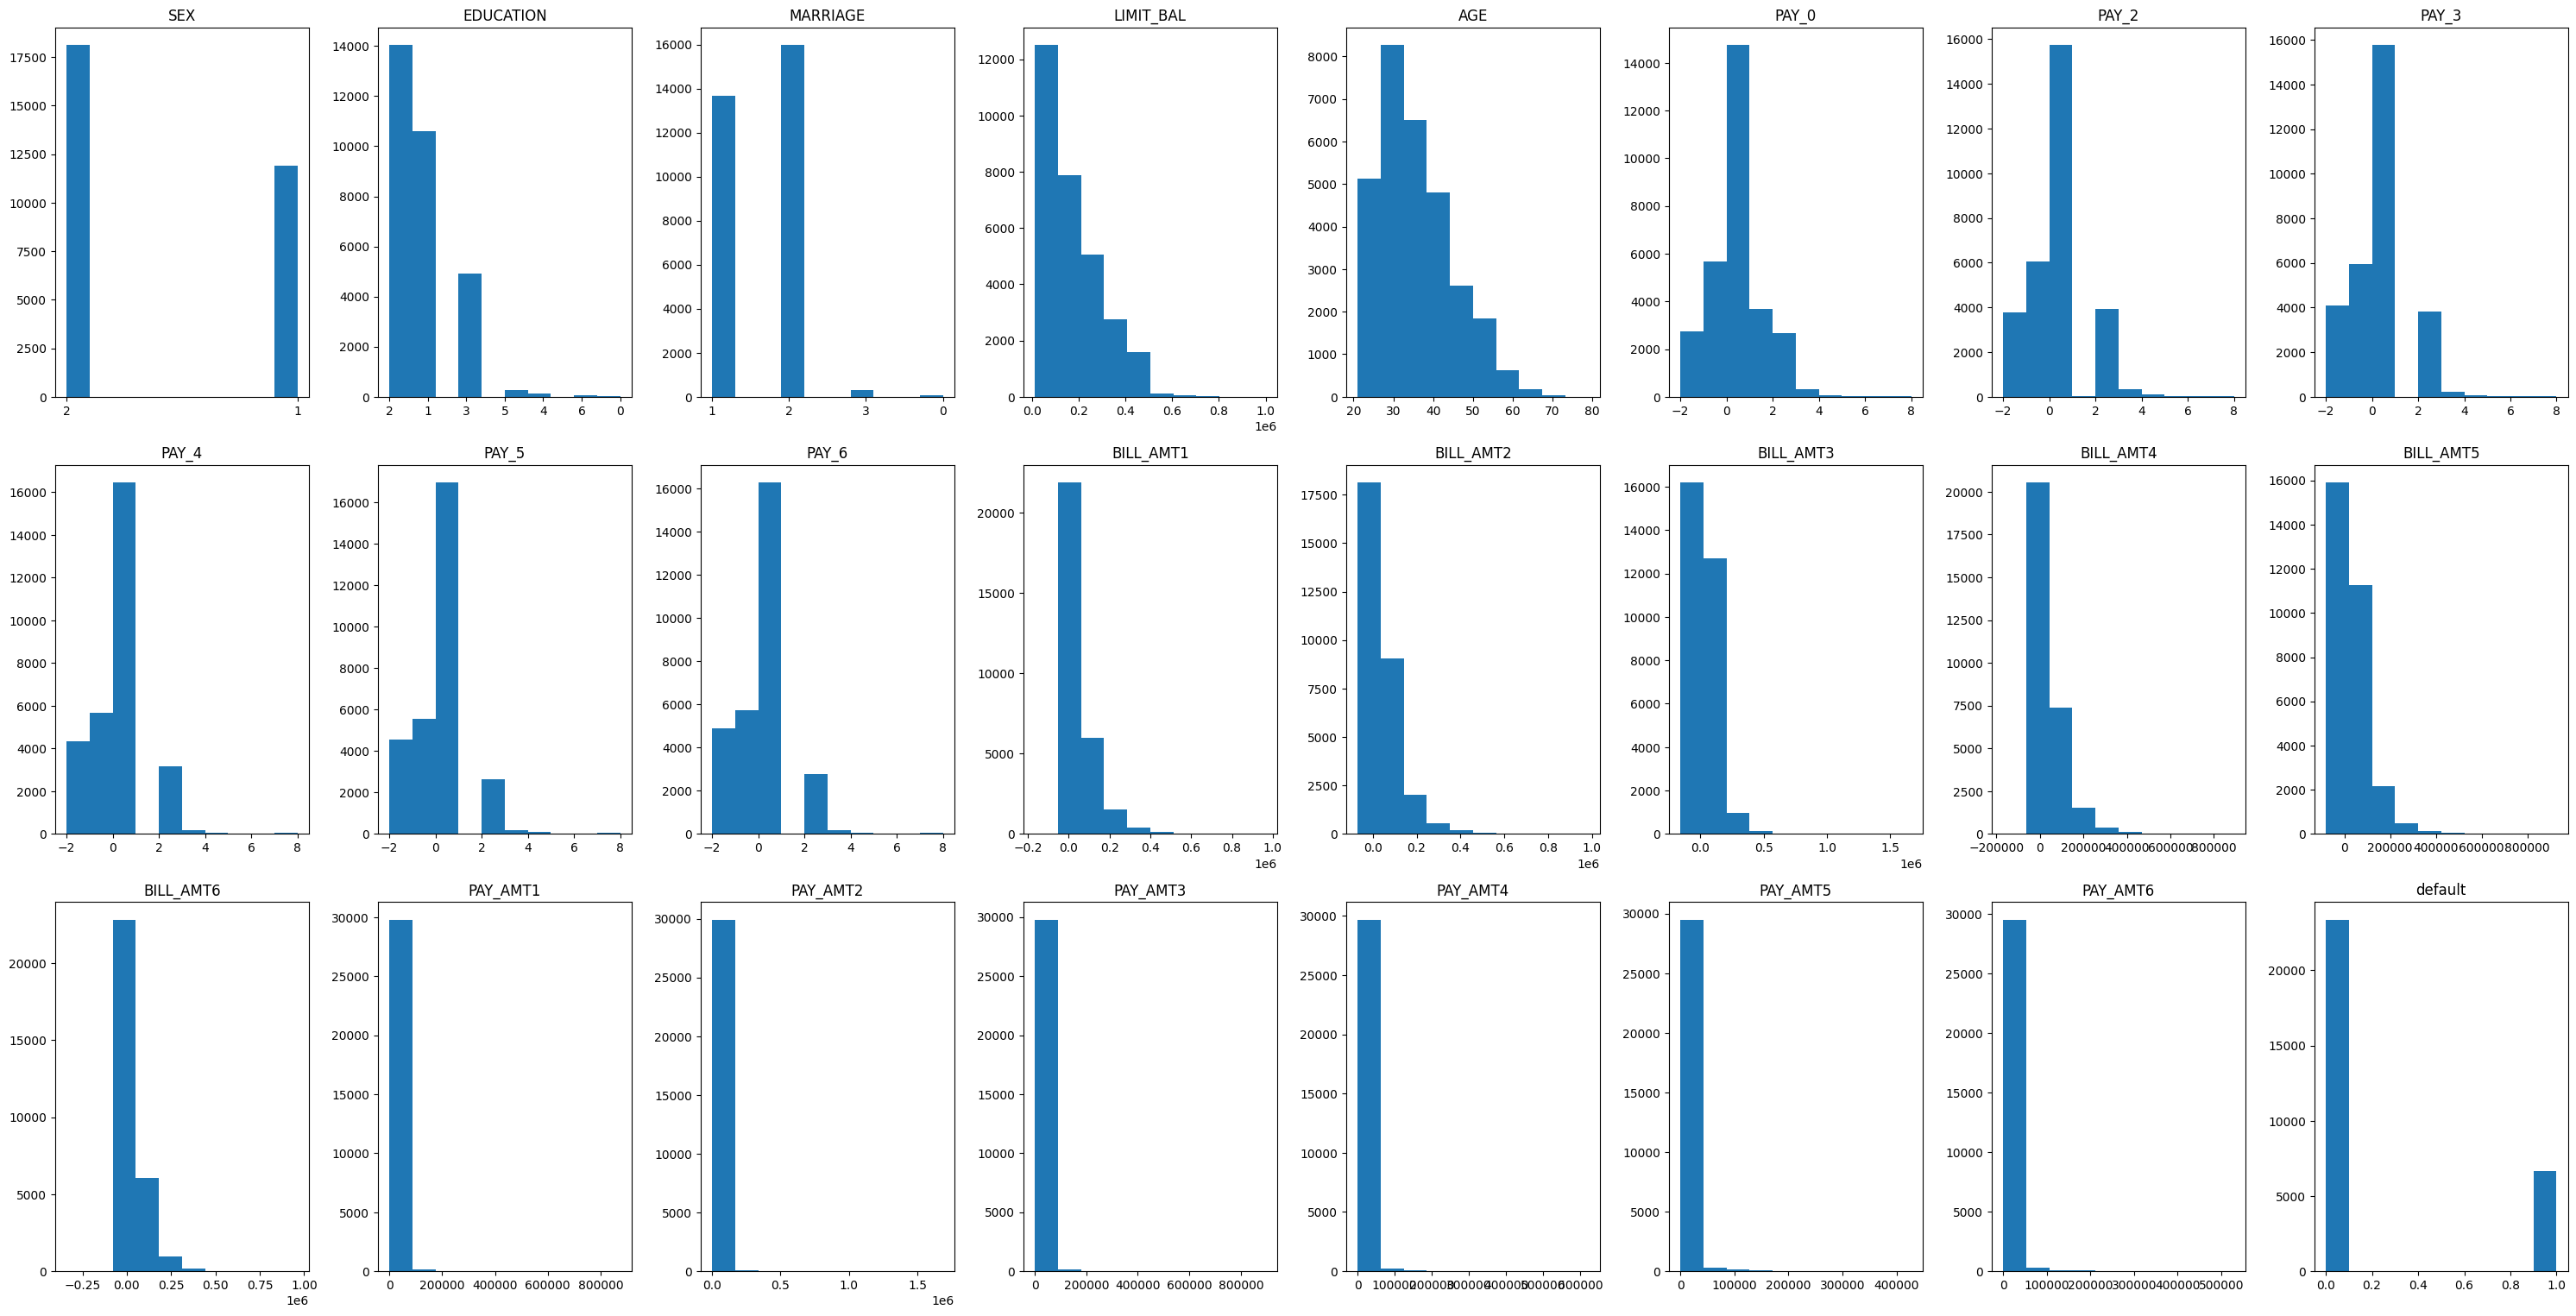

In [118]:
plt.figure(figsize=(30,20))
for ind,i in enumerate(df.columns):
    plt.subplot(4,8,ind+1)
    plt.title(i)
    plt.hist(i,data=df)
plt.tight_layout()
plt.show()

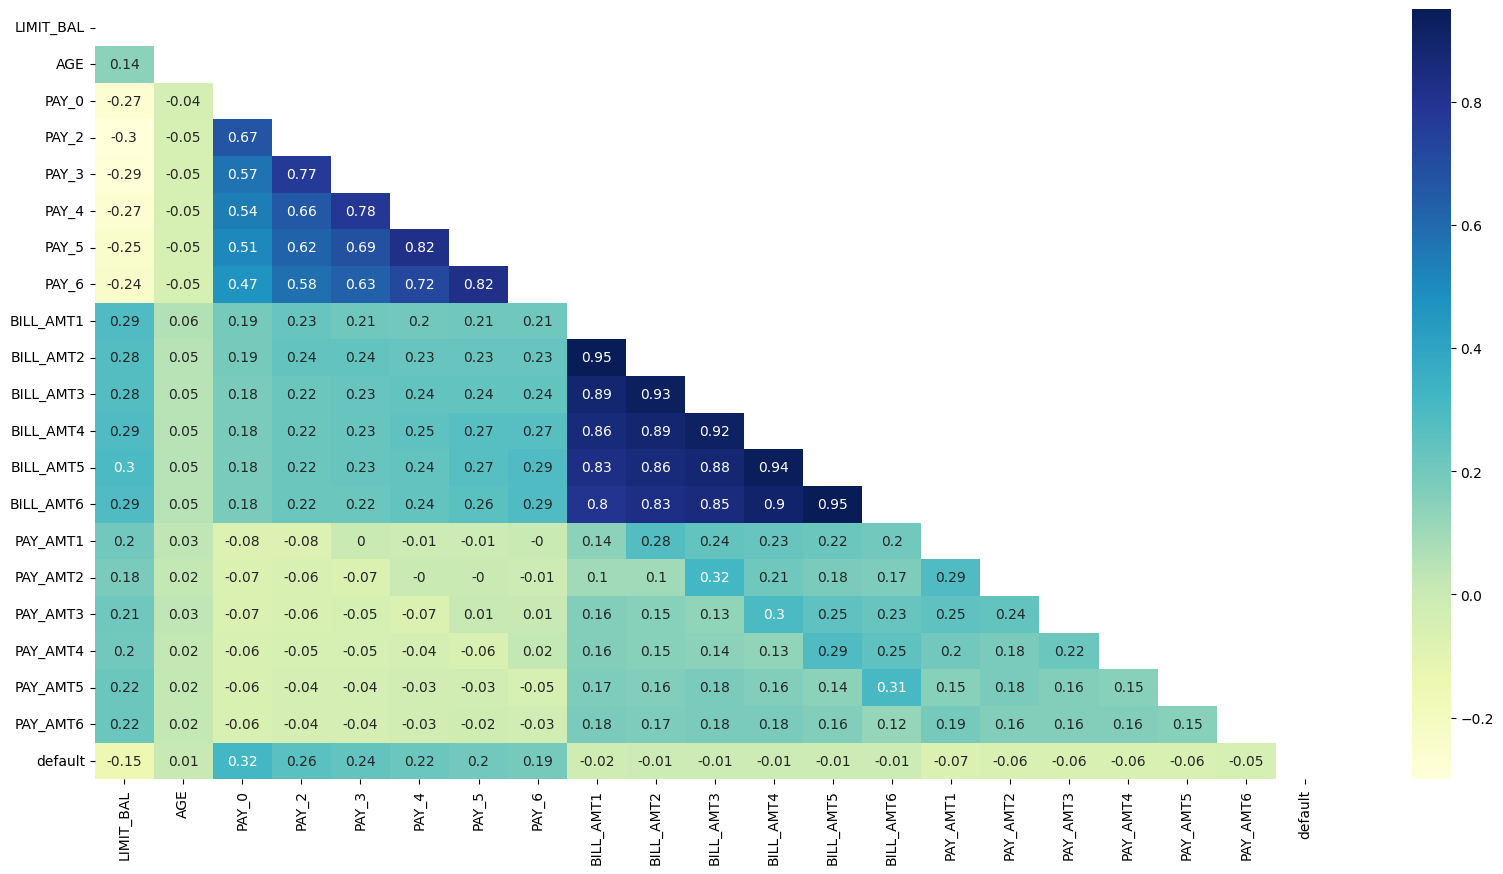

In [119]:
plt.figure(figsize=(20,10))
sns.heatmap(df[numeric_features + [target]].corr().round(2), cmap="YlGnBu", annot=True, mask = np.triu(np.ones_like(df[numeric_features + [target]].corr())))
plt.show()

### Feature Selection

#### Numeric Feature Selection Based on Variance

In [120]:
df[numeric_features].loc[:, df[numeric_features].var() > 0.9].columns.tolist()

['LIMIT_BAL',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

All numeric feature is selected since there is no feature with variance less than 0.9

#### Categoric Feature Selection Based on Chi Square

In [121]:
le = LabelEncoder()

_df = df.copy()

for feature in categorical_features:    
    _df[feature] = le.fit_transform(_df[feature])
_df['default'] = le.fit_transform(_df['default'])

X = _df[categorical_features]
y = _df['default']

selector = SelectKBest(score_func=chi2, k=3)
selector.fit(X, y)

feature_scores = selector.scores_
selected_features_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features_indices]

print("Chi-squared scores for each feature:", feature_scores)
print("Selected features:", selected_feature_names)

Chi-squared scores for each feature: [18.9833263   7.93125895  3.12000976]
Selected features: Index(['SEX', 'EDUCATION', 'MARRIAGE'], dtype='object')


Marriage is less important predictor compared to sex and education, but for first iteration we will keep the feature

#### Check Target Distribution

In [122]:
df.groupby('default')['default'].value_counts()

default
0    23364
1     6636
Name: count, dtype: int64

In [123]:
df.groupby('default')['default'].value_counts()/len(df)

default
0    0.7788
1    0.2212
Name: count, dtype: float64

The class is imbalance with majority of classes is non default, only 22% is identified as default

## Modeling

### Split data into train, validation, and test set

In [124]:
X_temp, X_test, y_temp, y_test = train_test_split(_df.drop(columns=['default']), _df['default'], test_size=0.2, random_state=42, stratify=_df['default'])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [125]:
# check size
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)

Training set size: (18000, 23)
Validation set size: (6000, 23)
Test set size: (6000, 23)


#### Pipeline for preprocessing

In [67]:
preprocessing_lr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
, remainder='drop'
)

preprocessing_svm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
, remainder='drop'
)

preprocessing_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
, remainder='drop'
)

#### Pipeline for model fitting

In [68]:
lr = Pipeline(steps=[
    ('pre', preprocessing_lr),
    ('clf', LogisticRegression(random_state=42, class_weight='balanced')) #class weight to handle imbalanced data
])


svm = Pipeline(steps=[
    ('pre', preprocessing_svm),
    ('clf', SVC(random_state=42, class_weight='balanced', probability=True)) #class weight to handle imbalanced data
])

rf = Pipeline(steps=[
    ('pre', preprocessing_rf),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced_subsample')) #class weight to handle imbalanced data
])

#### Model fitting and evaluation

In [69]:
model_lr = lr.fit(X_train, y_train)
model_svm = svm.fit(X_train, y_train)
model_rf = rf.fit(X_train, y_train)

In [70]:
print("Logistic Regression Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_lr.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_lr.predict(X_val))}")

Logistic Regression Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4673
           1       0.38      0.65      0.48      1327

    accuracy                           0.69      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.69      0.71      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.48396989127404516


In [71]:
print("SVM Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_svm.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_svm.predict(X_val))}")

SVM Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4673
           1       0.50      0.57      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.5339908418457203


In [72]:
print("Random Forest Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_rf.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_rf.predict(X_val))}")

Random Forest Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.52      0.63      4673
           1       0.25      0.56      0.34      1327

    accuracy                           0.53      6000
   macro avg       0.53      0.54      0.49      6000
weighted avg       0.68      0.53      0.57      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.34237995824634654


Based on model with default parameter (without hyperparameter tuning) SVC outperform logistic regression and random forest classifier

### Hyperparameter Tuning

In [73]:
param_lr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1.0, 0.5, 0.1]
}

param_svm = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly'],
    'clf__gamma': [0.001, 0.01, 0.1, 1] 
}

param_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

In [74]:
best_model_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_lr,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=4,
    random_state=42,
    error_score=0
)

best_model_scv = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_svm,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=4,
    random_state=42,
    error_score=0
)

best_model_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_rf,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=4,
    random_state=42,
    error_score=0
)

In [75]:
best_model_lr.fit(X_train, y_train)
best_model_scv.fit(X_train, y_train)
best_model_rf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Card Default Prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ........................clf__C=1.0, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=1.0, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=1.0, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=1.0, clf__penalty=l2; total time=   0.3s
[CV] END ........................clf__C=0.5, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.5, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.5, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=1.0, clf__penalty=l2; total time=   0.3s
[CV] END ........................clf__C=1.0, clf__penalty=l2; total time=   0.3s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ........................clf__C=0.1, clf__penalty=l1; total time=   0.0s
[CV] END ...................

/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Card Default Prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Card Default Prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Card

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .......clf__C=100, clf__gamma=0.01, clf__kernel=rbf; total time= 2.0min
[CV] END .....clf__C=10, clf__gamma=0.01, clf__kernel=linear; total time= 3.1min
[CV] END .....clf__C=10, clf__gamma=0.01, clf__kernel=linear; total time= 3.1min
[CV] END .....clf__C=10, clf__gamma=0.01, clf__kernel=linear; total time= 3.2min
[CV] END .......clf__C=100, clf__gamma=0.01, clf__kernel=rbf; total time= 1.9min
[CV] END ......clf__C=10, clf__gamma=0.001, clf__kernel=poly; total time= 1.7min
[CV] END ......clf__C=10, clf__gamma=0.001, clf__kernel=poly; total time= 1.7min
[CV] END .......clf__C=100, clf__gamma=0.01, clf__kernel=rbf; total time= 2.1min
[CV] END ......clf__C=10, clf__gamma=0.001, clf__kernel=poly; total time= 1.9min
[CV] END ........clf__C=100, clf__gamma=0.1, clf__kernel=rbf; total time= 2.0min
[CV] END ........clf__C=100, clf__gamma=0.1, clf__kernel=rbf; total time= 2.0min
[CV] END ........clf__C=100, clf__gamma=0.1, clf

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'clf__max_depth': [10, 20], 'clf__max_features': ['sqrt', 'log2'], 'clf__min_samples_leaf': [1, 2, ...], 'clf__min_samples_split': [2, 5, ...], ...}"
,n_iter,20
,scoring,'f1'
,n_jobs,4
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,0


In [76]:
print("Best Model Logistic Regression Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, best_model_lr.best_estimator_.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, best_model_lr.best_estimator_.predict(X_val))}")

Best Model Logistic Regression Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4673
           1       0.38      0.65      0.48      1327

    accuracy                           0.69      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.69      0.72      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.4844928751047779


In [77]:
print("Best Model SVC Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, best_model_scv.best_estimator_.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, best_model_scv.best_estimator_.predict(X_val))}")

Best Model SVC Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      4673
           1       0.50      0.55      0.52      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.5229555236728838


In [78]:
print("Best Model RF on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, best_model_rf.best_estimator_.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, best_model_rf.best_estimator_.predict(X_val))}")

Best Model RF on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.52      0.63      4673
           1       0.25      0.56      0.34      1327

    accuracy                           0.53      6000
   macro avg       0.53      0.54      0.49      6000
weighted avg       0.68      0.53      0.57      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.34237995824634654


In [79]:
results_df_lr = pd.DataFrame(best_model_lr.cv_results_)
results_df_svc = pd.DataFrame(best_model_scv.cv_results_)
results_df_rf = pd.DataFrame(best_model_rf.cv_results_)

In [80]:
results_df_lr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__penalty,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038742,0.006377,0.000000,0.000000,l1,1.0,"{'clf__penalty': 'l1', 'clf__C': 1.0}",0.000000,0.000000,0.000000,0.000000,0.000000,4
1,0.268190,0.020719,0.021979,0.004323,l2,1.0,"{'clf__penalty': 'l2', 'clf__C': 1.0}",0.473973,0.484193,0.479661,0.479276,0.004182,2
2,0.046635,0.002580,0.000000,0.000000,l1,0.5,"{'clf__penalty': 'l1', 'clf__C': 0.5}",0.000000,0.000000,0.000000,0.000000,0.000000,4
3,0.321293,0.027095,0.016612,0.001060,l2,0.5,"{'clf__penalty': 'l2', 'clf__C': 0.5}",0.473266,0.484734,0.479638,0.479213,0.004692,3
4,0.039723,0.003184,0.000000,0.000000,l1,0.1,"{'clf__penalty': 'l1', 'clf__C': 0.1}",0.000000,0.000000,0.000000,0.000000,0.000000,4
5,0.248877,0.032331,0.014127,0.002155,l2,0.1,"{'clf__penalty': 'l2', 'clf__C': 0.1}",0.474539,0.484438,0.481818,0.480265,0.004188,1


In [81]:
results_df_svc.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__kernel,param_clf__gamma,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,99.578957,3.896395,2.107937,0.175140,rbf,0.001,100.0,"{'clf__kernel': 'rbf', 'clf__gamma': 0.001, 'c...",0.527955,0.553446,0.524578,0.535326,0.012886,1
7,102.398083,3.834859,2.134736,0.166708,rbf,0.100,1.0,"{'clf__kernel': 'rbf', 'clf__gamma': 0.1, 'clf...",0.520176,0.547448,0.528354,0.531993,0.011427,2
1,119.727798,3.818224,2.062352,0.161761,rbf,0.010,100.0,"{'clf__kernel': 'rbf', 'clf__gamma': 0.01, 'cl...",0.525637,0.543663,0.520408,0.529903,0.009961,3
8,113.342295,3.623813,2.484284,0.044312,rbf,0.010,0.1,"{'clf__kernel': 'rbf', 'clf__gamma': 0.01, 'cl...",0.516316,0.541893,0.514160,0.524123,0.012596,4
9,93.934162,14.085539,2.085122,0.149318,rbf,0.001,10.0,"{'clf__kernel': 'rbf', 'clf__gamma': 0.001, 'c...",0.516673,0.535078,0.509455,0.520402,0.010788,5
0,186.233110,3.802431,1.089449,0.083727,linear,0.010,10.0,"{'clf__kernel': 'linear', 'clf__gamma': 0.01, ...",0.511026,0.526499,0.501624,0.513050,0.010256,6
4,178.355697,5.822232,0.961079,0.106058,linear,0.001,10.0,"{'clf__kernel': 'linear', 'clf__gamma': 0.001,...",0.511026,0.526499,0.501624,0.513050,0.010256,6
6,96.128008,3.275005,0.968732,0.062518,linear,0.001,1.0,"{'clf__kernel': 'linear', 'clf__gamma': 0.001,...",0.509982,0.525949,0.502165,0.512699,0.009898,8
3,116.058552,2.184165,1.694917,0.091106,rbf,0.100,100.0,"{'clf__kernel': 'rbf', 'clf__gamma': 0.1, 'clf...",0.415950,0.430939,0.426648,0.424512,0.006303,9
2,103.101844,5.153835,2.948861,0.367523,poly,0.001,10.0,"{'clf__kernel': 'poly', 'clf__gamma': 0.001, '...",0.023704,0.025092,0.029564,0.026120,0.002500,10


In [82]:
results_df_rf.sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__n_estimators,param_clf__min_samples_split,param_clf__min_samples_leaf,param_clf__max_features,param_clf__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,2.107226,0.022574,0.071361,0.002068,300,10,1,sqrt,20,"{'clf__n_estimators': 300, 'clf__min_samples_s...",0.358864,0.331031,0.345552,0.345149,0.011366,1
15,0.718151,0.026338,0.029583,0.002073,100,10,2,sqrt,20,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.358864,0.331031,0.345552,0.345149,0.011366,1
19,0.703464,0.007632,0.027388,0.000545,100,10,2,log2,10,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.358864,0.331031,0.345552,0.345149,0.011366,1
10,0.715770,0.011721,0.027212,0.000850,100,2,1,log2,20,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.359063,0.330795,0.345552,0.345137,0.011544,4
12,0.732186,0.027630,0.028596,0.001683,100,2,1,sqrt,10,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.359063,0.330795,0.345552,0.345137,0.011544,4
6,0.711855,0.015915,0.027710,0.000994,100,5,1,log2,10,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.358864,0.330795,0.345552,0.345070,0.011464,6
3,2.123974,0.060394,0.067724,0.000294,300,2,1,log2,20,"{'clf__n_estimators': 300, 'clf__min_samples_s...",0.358864,0.330795,0.345552,0.345070,0.011464,6
1,1.282111,0.041641,0.044348,0.000605,200,2,2,sqrt,10,"{'clf__n_estimators': 200, 'clf__min_samples_s...",0.358864,0.330795,0.345552,0.345070,0.011464,6
14,0.632708,0.032208,0.025052,0.000876,100,2,4,sqrt,10,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.358864,0.330795,0.345552,0.345070,0.011464,6
7,0.686072,0.009319,0.026621,0.001251,100,2,4,log2,10,"{'clf__n_estimators': 100, 'clf__min_samples_s...",0.358864,0.330795,0.345552,0.345070,0.011464,6


As the model not showing improvement after hyperparameter tuning we will adjust the probability to get best f1 score. Why F1 score is choosen?
1. For default we want to minimize customers that will be default in the future, for this case we will maximize recall
2. For the business problem, if the model very conservative (maximize recall) we will not have business opportunity

For accomodating both conversative, and not missing opportunities for the business we will maximize f1 score as this score will find harmonic mean from both score

**Since the model not showing progression after hyperparameter tuning with several parameter, we will continue to adjust the treshold to maximize f1 score**

Calculating F1 scores for each threshold...


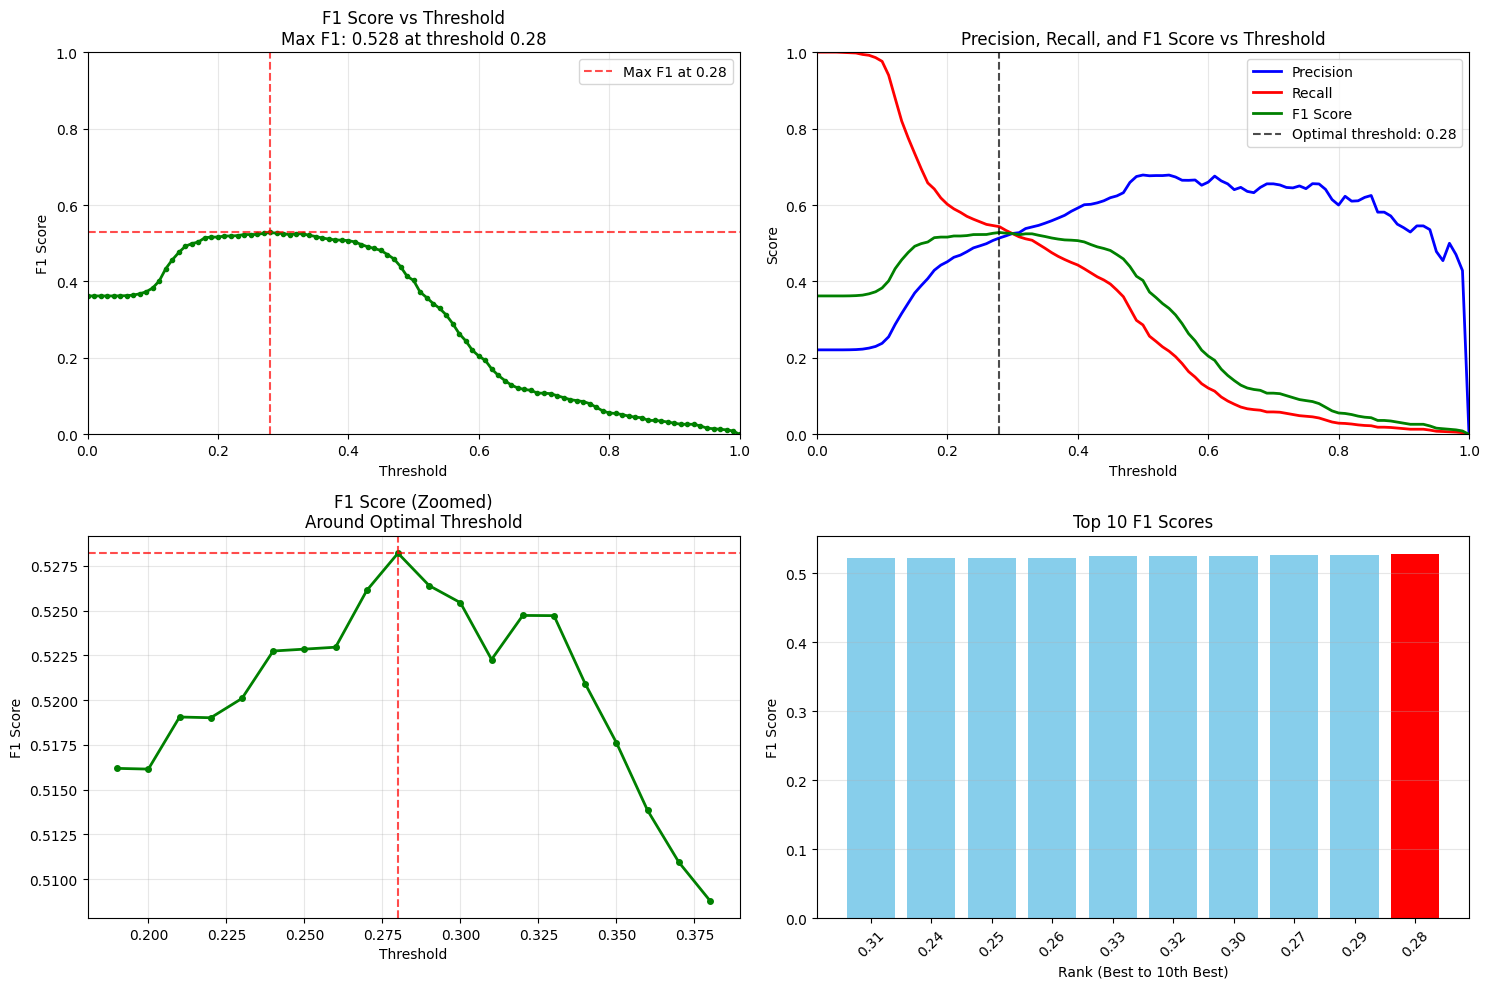


F1 SCORE ANALYSIS RESULTS
Optimal Threshold: 0.28
Maximum F1 Score: 0.528
Precision at optimal threshold: 0.514
Recall at optimal threshold: 0.543
F1 Formula verification: 2*P*R/(P+R) = 2*0.514*0.543/(0.514+0.543) = 0.528

Top 5 thresholds with highest F1 scores:
----------------------------------------
1. Threshold: 0.28, F1: 0.528, Precision: 0.514, Recall: 0.543
2. Threshold: 0.29, F1: 0.526, Precision: 0.519, Recall: 0.534
3. Threshold: 0.27, F1: 0.526, Precision: 0.507, Recall: 0.546
4. Threshold: 0.30, F1: 0.525, Precision: 0.526, Recall: 0.525
5. Threshold: 0.32, F1: 0.525, Precision: 0.538, Recall: 0.512


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 [0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.3621961212783392,
  0.362417943107221,
  0.36303811351795995,
  0.36436464088397785,
  0.3678032420346563,
  0.37312794180573383,
  0.38307942612039636,
  0.40148100450740504,
  0.4335872190228497,
  0.4566631689401888,
  0.

In [83]:
calculate_f1_scores_across_thresholds(best_model_scv.best_estimator_, X_val, y_val)

### Find feature importance to generate final feature

In [88]:
# Using the test set for evaluation
result = permutation_importance(model_lr, X_val, y_val, n_repeats=10, random_state=42, scoring='f1')

In [93]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_val.columns[sorted_importances_idx],
)

# Display the mean importance and standard deviation for each feature
for i in sorted_importances_idx[::-1]:
    print(
        f"{X_val.columns[i]:<8}"
        f" {result.importances_mean[i]:.3f}"
        f" +/- {result.importances_std[i]:.3f}"
    )

PAY_AMT6 0.105 +/- 0.001
PAY_AMT5 0.052 +/- 0.001
PAY_AMT4 0.008 +/- 0.001
PAY_AMT3 0.008 +/- 0.000
PAY_AMT2 0.007 +/- 0.004
PAY_AMT1 0.007 +/- 0.002
BILL_AMT6 0.006 +/- 0.002
BILL_AMT5 0.005 +/- 0.002
BILL_AMT4 0.005 +/- 0.002
BILL_AMT3 0.005 +/- 0.002
BILL_AMT2 0.005 +/- 0.001
BILL_AMT1 0.004 +/- 0.004
PAY_6    0.004 +/- 0.002
PAY_5    0.003 +/- 0.001
PAY_4    0.002 +/- 0.002
PAY_3    0.001 +/- 0.003
PAY_2    0.001 +/- 0.002
PAY_0    0.000 +/- 0.007
AGE      -0.000 +/- 0.002
LIMIT_BAL -0.001 +/- 0.004
MARRIAGE -0.001 +/- 0.005
EDUCATION -0.001 +/- 0.002
SEX      -0.001 +/- 0.001


Based on permutation importance, it looks like pay, age, limit_bal, marriage, education, and sex 

In [133]:
new_features = [
    "PAY_AMT6"
    ,"PAY_AMT5"
    ,"PAY_AMT4"
    ,"PAY_AMT3"
    ,"PAY_AMT2"
    ,"PAY_AMT1"
    ,"BILL_AMT6"
    ,"BILL_AMT5"
    ,"BILL_AMT4"
    ,"BILL_AMT3"
    ,"BILL_AMT2"
    ,"BILL_AMT1"
    ,"PAY_6"
    ,"PAY_5"
    ,"PAY_4"
    ,"PAY_3"
    ,"PAY_2"
    ,"PAY_0"
]

### Retrain model with selected features only

In [134]:
X_train_final = X_train[new_features].copy()
X_val_final = X_val[new_features].copy()
X_test_final = X_test[new_features].copy()

In [135]:
preprocessing_lr = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), new_features)
    ]
, remainder='drop'
)

preprocessing_svm = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), new_features)
    ]
, remainder='drop'
)


In [129]:
lr = Pipeline(steps=[
    ('pre', preprocessing_lr),
    ('clf', LogisticRegression(random_state=42, class_weight='balanced')) #class weight to handle imbalanced data
])


svm = Pipeline(steps=[
    ('pre', preprocessing_svm),
    ('clf', SVC(random_state=42, class_weight='balanced', probability=True)) #class weight to handle imbalanced data
])

In [130]:
model_lr = lr.fit(X_train, y_train)
model_svm = svm.fit(X_train, y_train)

In [131]:
print("Logistic Regression Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_lr.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_lr.predict(X_val))}")

Logistic Regression Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      4673
           1       0.42      0.60      0.49      1327

    accuracy                           0.72      6000
   macro avg       0.64      0.68      0.65      6000
weighted avg       0.77      0.72      0.74      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.4927803379416283


In [132]:
print("SVM Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_svm.predict(X_val)))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_svm.predict(X_val))}")

SVM Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.50      0.57      0.53      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.70      0.69      6000
weighted avg       0.79      0.78      0.78      6000

----------------------------------------------------------------------------------------------------
F1 Score:0.5279831045406547


In [136]:
param_lr = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [1.0, 0.5, 0.1],
    'clf__max_iter': [100, 200, 300, 500, 1000],
    'clf__solver': ['liblinear', 'lbfgs']
}

best_model_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_lr,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=4,
    random_state=42,
    error_score=0
)

best_model_lr.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END clf__C=1.0, clf__max_iter=200, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=1.0, clf__max_iter=200, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=1.0, clf__max_iter=200, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.5, clf__max_iter=1000, clf__penalty=l1, clf__solver=liblinear; total time=   0.4s
[CV] END clf__C=1.0, clf__max_iter=100, clf__penalty=l1, clf__solver=liblinear; total time=   0.7s
[CV] END clf__C=1.0, clf__max_iter=100, clf__penalty=l1, clf__solver=liblinear; total time=   1.0s
[CV] END clf__C=1.0, clf__max_iter=100, clf__penalty=l1, clf__solver=liblinear; total time=   0.9s
[CV] END clf__C=0.1, clf__max_iter=200, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.1, clf__max_iter=200, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.1, clf__max_iter=200, clf__penalty=l1, clf__solve

/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Card Default Prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Card Default Prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ihsannurfaqih/Documents/Ihsan Nur Faqih/Project/Data Science General Project/Credit Ca

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'clf__C': [1.0, 0.5, ...], 'clf__max_iter': [100, 200, ...], 'clf__penalty': ['l1', 'l2'], 'clf__solver': ['liblinear', 'lbfgs']}"
,n_iter,10
,scoring,'f1'
,n_jobs,4
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,0


In [140]:
pd.DataFrame(best_model_lr.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__solver,param_clf__penalty,param_clf__max_iter,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,0.188628,0.066617,0.011261,0.002594,liblinear,l1,300,0.1,"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.518519,0.521882,0.508416,0.516272,0.005722,1
2,0.425328,0.106475,0.013864,0.004306,liblinear,l1,1000,0.5,"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.505964,0.494979,0.491003,0.497315,0.006327,2
0,0.845732,0.147660,0.013526,0.002789,liblinear,l1,100,1.0,"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.497727,0.492050,0.487541,0.492439,0.004167,3
8,0.607258,0.156139,0.006081,0.001237,liblinear,l1,500,1.0,"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.497727,0.492050,0.487541,0.492439,0.004167,3
5,0.190445,0.009907,0.010583,0.000740,liblinear,l2,500,0.1,"{'clf__solver': 'liblinear', 'clf__penalty': '...",0.491029,0.482209,0.482274,0.485171,0.004143,5
3,0.028688,0.003539,0.000000,0.000000,lbfgs,l1,200,0.1,"{'clf__solver': 'lbfgs', 'clf__penalty': 'l1',...",0.000000,0.000000,0.000000,0.000000,0.000000,6
4,0.034645,0.005112,0.000000,0.000000,lbfgs,l1,500,1.0,"{'clf__solver': 'lbfgs', 'clf__penalty': 'l1',...",0.000000,0.000000,0.000000,0.000000,0.000000,6
1,0.025250,0.001608,0.000000,0.000000,lbfgs,l1,200,1.0,"{'clf__solver': 'lbfgs', 'clf__penalty': 'l1',...",0.000000,0.000000,0.000000,0.000000,0.000000,6
6,0.028883,0.000333,0.000000,0.000000,lbfgs,l1,500,0.5,"{'clf__solver': 'lbfgs', 'clf__penalty': 'l1',...",0.000000,0.000000,0.000000,0.000000,0.000000,6
9,0.023937,0.001459,0.000000,0.000000,lbfgs,l1,1000,0.1,"{'clf__solver': 'lbfgs', 'clf__penalty': 'l1',...",0.000000,0.000000,0.000000,0.000000,0.000000,6


In [141]:
best_model_lr.best_score_

np.float64(0.5162723561263824)

##### Find the best treshold

Calculating F1 scores for each threshold...


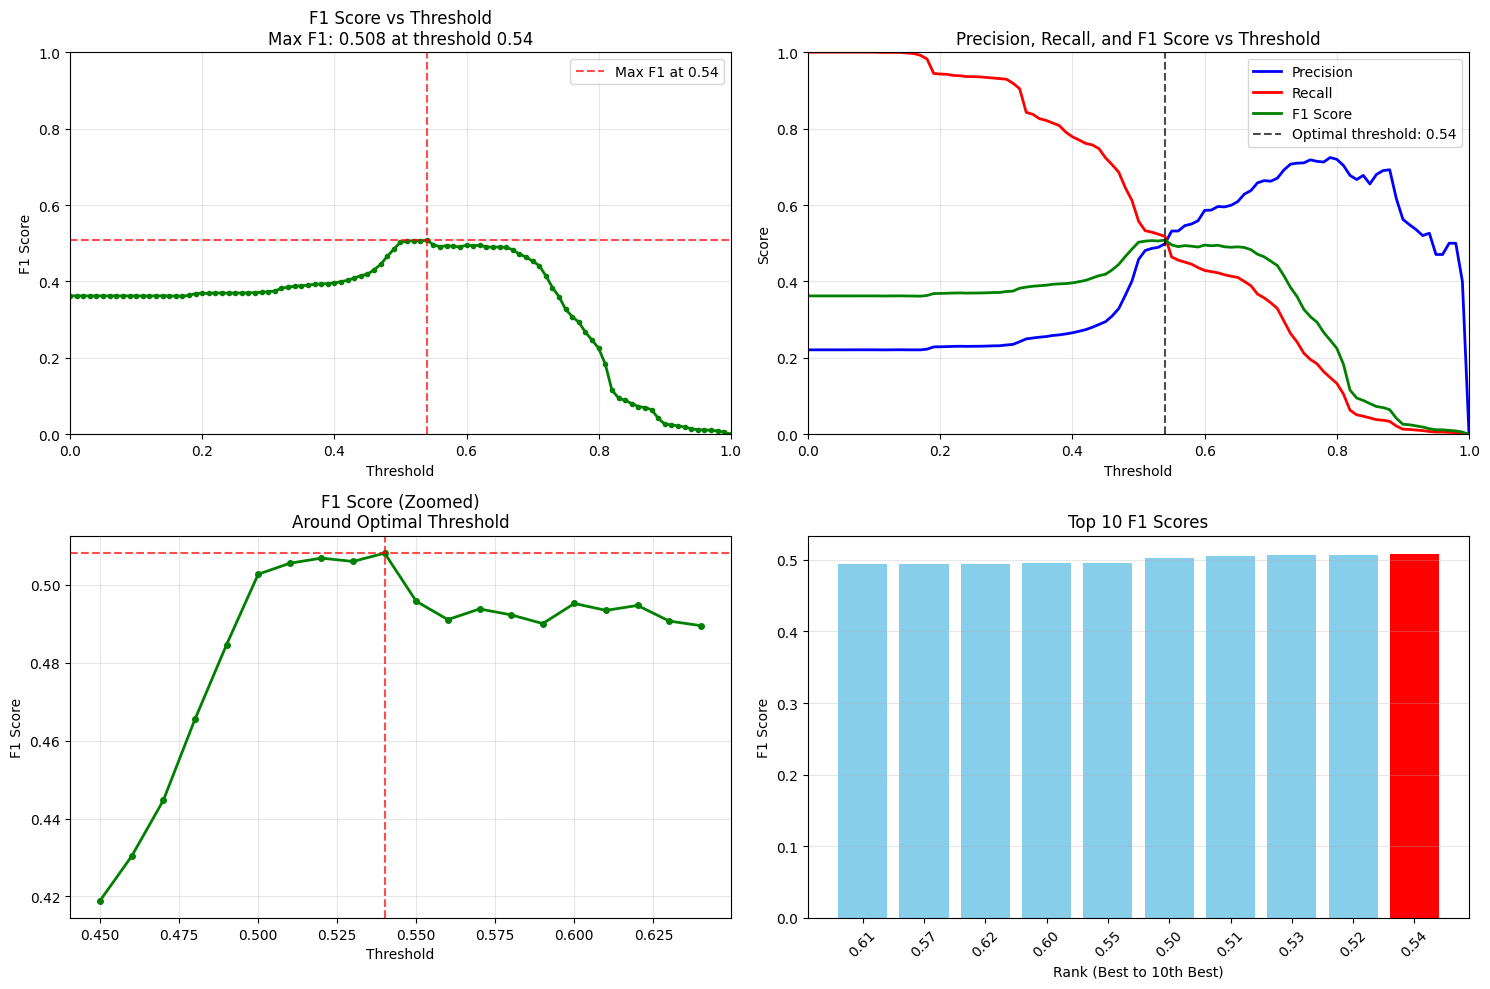


F1 SCORE ANALYSIS RESULTS
Optimal Threshold: 0.54
Maximum F1 Score: 0.508
Precision at optimal threshold: 0.499
Recall at optimal threshold: 0.518
F1 Formula verification: 2*P*R/(P+R) = 2*0.499*0.518/(0.499+0.518) = 0.508

Top 5 thresholds with highest F1 scores:
----------------------------------------
1. Threshold: 0.54, F1: 0.508, Precision: 0.499, Recall: 0.518
2. Threshold: 0.52, F1: 0.507, Precision: 0.486, Recall: 0.529
3. Threshold: 0.53, F1: 0.506, Precision: 0.489, Recall: 0.524
4. Threshold: 0.51, F1: 0.506, Precision: 0.481, Recall: 0.533
5. Threshold: 0.50, F1: 0.503, Precision: 0.458, Recall: 0.558


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 [0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.3622713622713623,
  0.3622713622713623,
  0.3622713622713623,
  0.3622713622713623,
  0.3620477815699658,
  0.3620477815699658,
  0.3622950819672131,
  0.3623940

In [143]:
calculate_f1_scores_across_thresholds(best_model_lr.best_estimator_, X_val, y_val)

In [144]:
X_train_full = pd.concat([X_train, X_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)

Calculating F1 scores for each threshold...


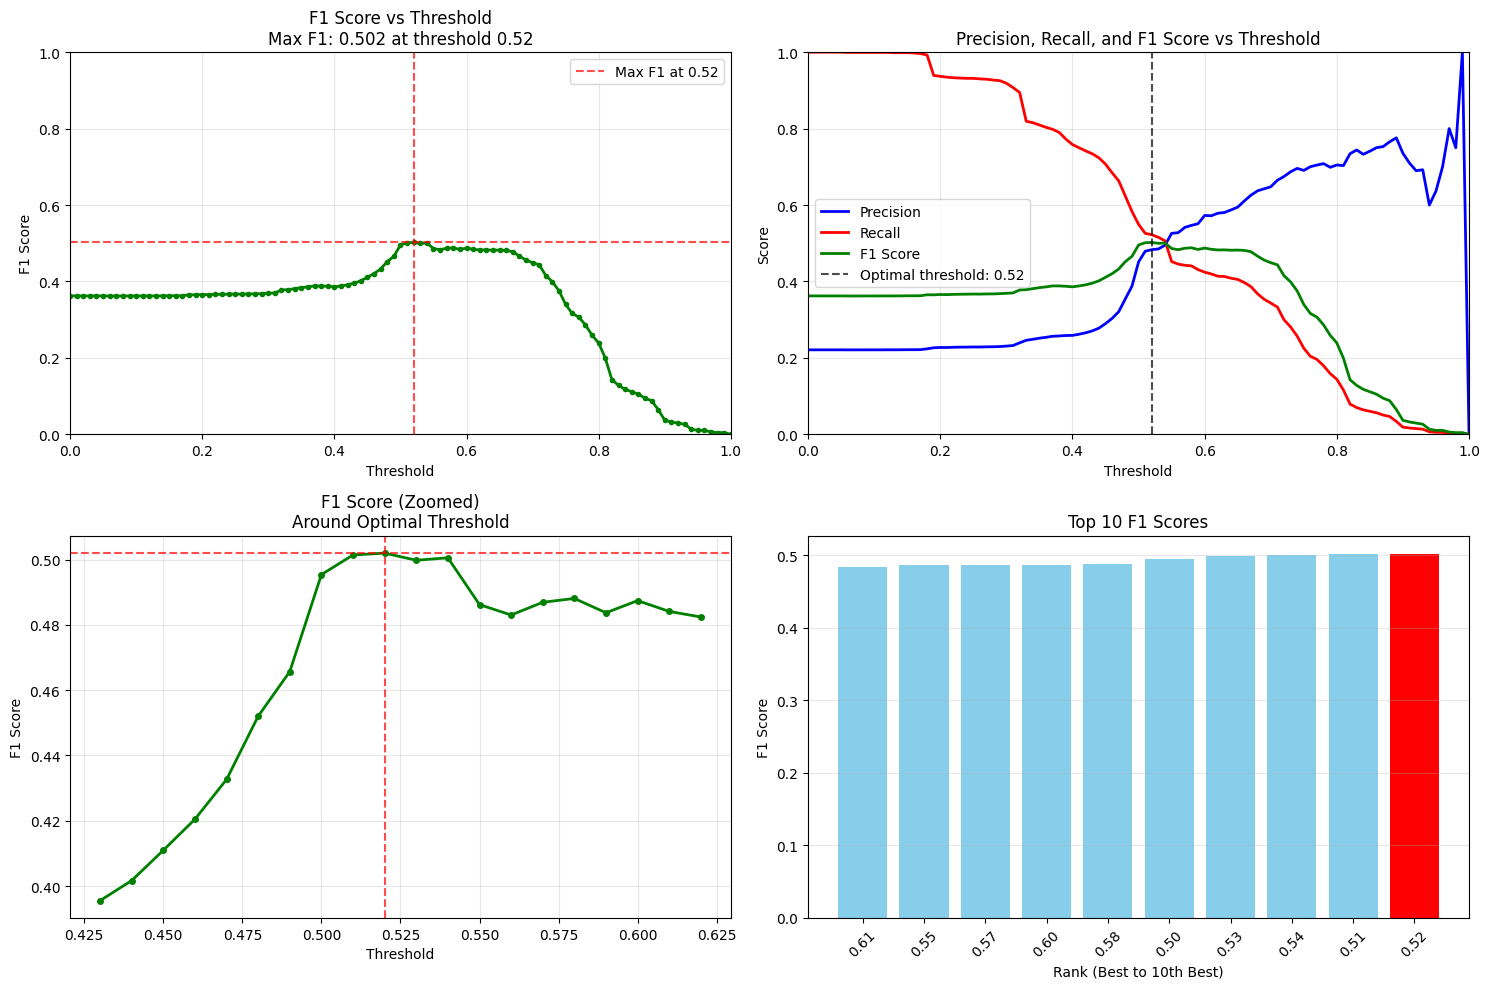


F1 SCORE ANALYSIS RESULTS
Optimal Threshold: 0.52
Maximum F1 Score: 0.502
Precision at optimal threshold: 0.483
Recall at optimal threshold: 0.522
F1 Formula verification: 2*P*R/(P+R) = 2*0.483*0.522/(0.483+0.522) = 0.502

Top 5 thresholds with highest F1 scores:
----------------------------------------
1. Threshold: 0.52, F1: 0.502, Precision: 0.483, Recall: 0.522
2. Threshold: 0.51, F1: 0.501, Precision: 0.479, Recall: 0.526
3. Threshold: 0.54, F1: 0.501, Precision: 0.495, Recall: 0.506
4. Threshold: 0.53, F1: 0.500, Precision: 0.485, Recall: 0.515
5. Threshold: 0.50, F1: 0.495, Precision: 0.451, Recall: 0.549


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 [0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.362221918929985,
  0.361998361998362,
  0.3620477815699658,
  0.3620972146368105,
  0.3620972146368105,
  0.3621466612044244,
  0.3621466612044244,
  0.3622455948640896,
  0.36217028836955034,
  0.362318

In [145]:
calculate_f1_scores_across_thresholds(best_model_lr.best_estimator_, X_test, y_test)

In [147]:
print(classification_report(y_test, best_model_lr.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      4673
           1       0.45      0.55      0.50      1327

    accuracy                           0.75      6000
   macro avg       0.66      0.68      0.67      6000
weighted avg       0.77      0.75      0.76      6000



In [148]:
y_pred = (best_model_lr.best_estimator_.predict_proba(X_test)[:, 1]>=0.52).astype(int)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4673
           1       0.48      0.52      0.50      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.68      0.68      6000
weighted avg       0.78      0.77      0.77      6000



In [149]:
best_model_lr.best_params_

{'clf__solver': 'liblinear',
 'clf__penalty': 'l1',
 'clf__max_iter': 300,
 'clf__C': 0.1}

In [156]:
final_model = Pipeline(steps=[
    ('pre', preprocessing_lr),
    ('clf', LogisticRegression(
    penalty=best_model_lr.best_params_['clf__penalty'],
    C=best_model_lr.best_params_['clf__C'],
    max_iter=best_model_lr.best_params_['clf__max_iter'],
    solver=best_model_lr.best_params_['clf__solver'],
    random_state=42,
    class_weight='balanced'
))
])



In [157]:
final_model.fit(X_train_full, y_train_full)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [160]:
print(classification_report(y_test, final_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4673
           1       0.44      0.56      0.49      1327

    accuracy                           0.74      6000
   macro avg       0.65      0.68      0.66      6000
weighted avg       0.77      0.74      0.75      6000



In [162]:
with open("../model/final_model.bin", "wb") as f:
    pickle.dump(final_model, f)

In [163]:
X_train_final

,PAY_AMT6,PAY_AMT5,PAY_AMT4,PAY_AMT3,PAY_AMT2,PAY_AMT1,BILL_AMT6,BILL_AMT5,BILL_AMT4,BILL_AMT3,BILL_AMT2,BILL_AMT1,PAY_6,PAY_5,PAY_4,PAY_3,PAY_2,PAY_0
10574,0,0,0,0,0,2000,0,0,0,0,20650,19255,-2,-2,-2,0,0,0
11330,3039,5063,5007,5027,15056,12507,124882,128742,131103,298378,291480,285038,0,0,0,0,0,0
7127,9905,54379,201,49450,48276,99159,54109,40018,49403,48017,97882,33179,-1,0,-1,-1,-1,-1
25150,1000,1200,1200,2600,3700,2600,26738,29510,59665,71318,70068,70349,0,0,0,0,0,0
6000,0,390,109,264,1284,2000,5440,5440,6753,6879,9199,13538,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22847,2000,13000,2000,2000,2000,2000,49542,40334,42045,46979,45746,67940,0,0,0,0,0,0
17496,220,21,4,1411,1708,2158,7254,8723,22063,22348,49884,52062,0,0,0,0,0,2
2145,6000,4902,0,11760,5695,14000,4902,0,11760,169759,166176,171098,-1,-1,-1,0,0,0
15305,0,0,0,0,5000,8000,0,0,0,92887,89589,83013,-2,-2,0,0,0,0
